# M5 - Sales Uncertainty Prediction

1. [Sources and guidelines](#sources)
2. [Preparing to start](#prepare)
    * [Loading packages](#packages)
    * [Loading data](#data)
3. ["What is meant by probabilistic forecasting?"...](#prob_forecasting)
    * [What is a grouped time series?](#grouped_ts)
    * [How does the hierarchy look like?](#hierarchy_ts)
    * [How can we generate forecasts for grouped timeseries?](#forecasts_ts)
4. [The submission format](#submission)
    * [Intro](#intro)
    * [Prediction intervals and quartiles](#PIs)
    * [Aggregation levels](#sub_aggregation_levels)
    * [Submission EDA](#submission_eda)
5. [The Weighted Scaled Pinball loss](#loss)
    * [The formula](#formula)
    * [Playing with the loss implementation](#loss_implementation)
6. [The Naive method](#naive)
    * [Prediction intervals for the Naive method](#prediction_intervals_naive)
    * [Computing the loss for one timeseries of level 12](#loss_example)
7. [Facebook's Prophet](#prophet)
8. [LSTM and bootstrapped residuals](#lstm_bootstrapped_res)
    * [Basic idea](#basic_idea)
    * [Setting up LSTM](#lstm_setup)
    * [Fitting the model to the top-level series](#fitting_lstm)
    * [Check residuals for autocorrelation ](#residuals_checkup)
    * [Computing PIs using bootstrapped residuals](#bootstrapped_PIs)
9. [Where to go next?](#next)

# Sources and guidelines <a class="anchor" id="sources"></a>

* [M5 Competition guideline](https://mofc.unic.ac.cy/m5-competition/)
* [M5 github repository](https://github.com/Mcompetitions/M5-methods/tree/master/validation)
* [Forecasting - Principles and Practice (by Rob J Hyndman and George Athanasopoulos)](https://otexts.com/fpp2/)

# Preparing to start <a class="anchor" id="prepare"></a>

## Loading packages <a class="anchor" id="packages"></a>

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()


import time
from tqdm import tqdm_notebook as tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/m5-forecasting-uncertainty/sample_submission.csv
/kaggle/input/m5-forecasting-uncertainty/sales_train_validation.csv
/kaggle/input/m5-forecasting-uncertainty/calendar.csv
/kaggle/input/m5-forecasting-uncertainty/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-uncertainty/sell_prices.csv


## Loading data <a class="anchor" id="data"></a>

### Sales Training Data

In [2]:
train = pd.read_csv("/kaggle/input/m5-forecasting-uncertainty/sales_train_validation.csv")
train.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [3]:
train.shape

(30490, 1919)

### Calendar information

In [4]:
calendar = pd.read_csv("/kaggle/input/m5-forecasting-uncertainty/calendar.csv")
calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

### Sell prices information

In [5]:
sell_prices = pd.read_csv("/kaggle/input/m5-forecasting-uncertainty/sell_prices.csv")
sell_prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

# "What is meant by probabilistic forecasting?"... <a class="anchor" id="prob_forecasting"></a>

When I read about this competition this was one of the first questions that came into my mind. I know a few probabilistic models and methods and I have done some time series analysis before but I haven't directly got in touch with probabilistic timeseries analysis so far. The M5 competition is a good way to close this gap and to learn something new. To start I like to follow a question driven approach...

## What is a grouped time series? <a class="anchor" id="grouped_ts"></a>

* Reading the competiton guideline we can find out that we have to deal with grouped time series of unit sales data. 
* They show a hierarchy of different aggregation levels that are weighted equally in the loss functions. 
* When working with grouped time series it's common to compute forecasts only for disaggregated time series and to add them up the same way the aggregation is performed for all remaining time series. 
* In Chapter 10 of [Forecasting - Principles and Practice](https://otexts.com/fpp2/hierarchical.html) we can find even more information about how to do this "forecasting aggregation".

## How does the hierarchy look like? <a class="anchor" id="hierarchy_ts"></a>

In the competition guideline we can find that the hierarchy consits of 12 levels. Let's try to reconstruct some of them:

1. The top is given by the unit sales of all products, aggregated for all stores/states. 
2. Unit sales of all products, aggregated for each state.
3. Unit sales of all products, aggregated for each store.
4. Unit sales of all products, aggregated for each category.
5. Unit sales of all products, aggregated for each department.

...

Ok, time for a vis: ;-)

In [6]:
series_cols = train.columns[train.columns.str.contains("d_")].values
level_cols = train.columns[train.columns.str.contains("d_")==False].values

In [7]:
train.head(1)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  

[1 rows x 1919 columns]

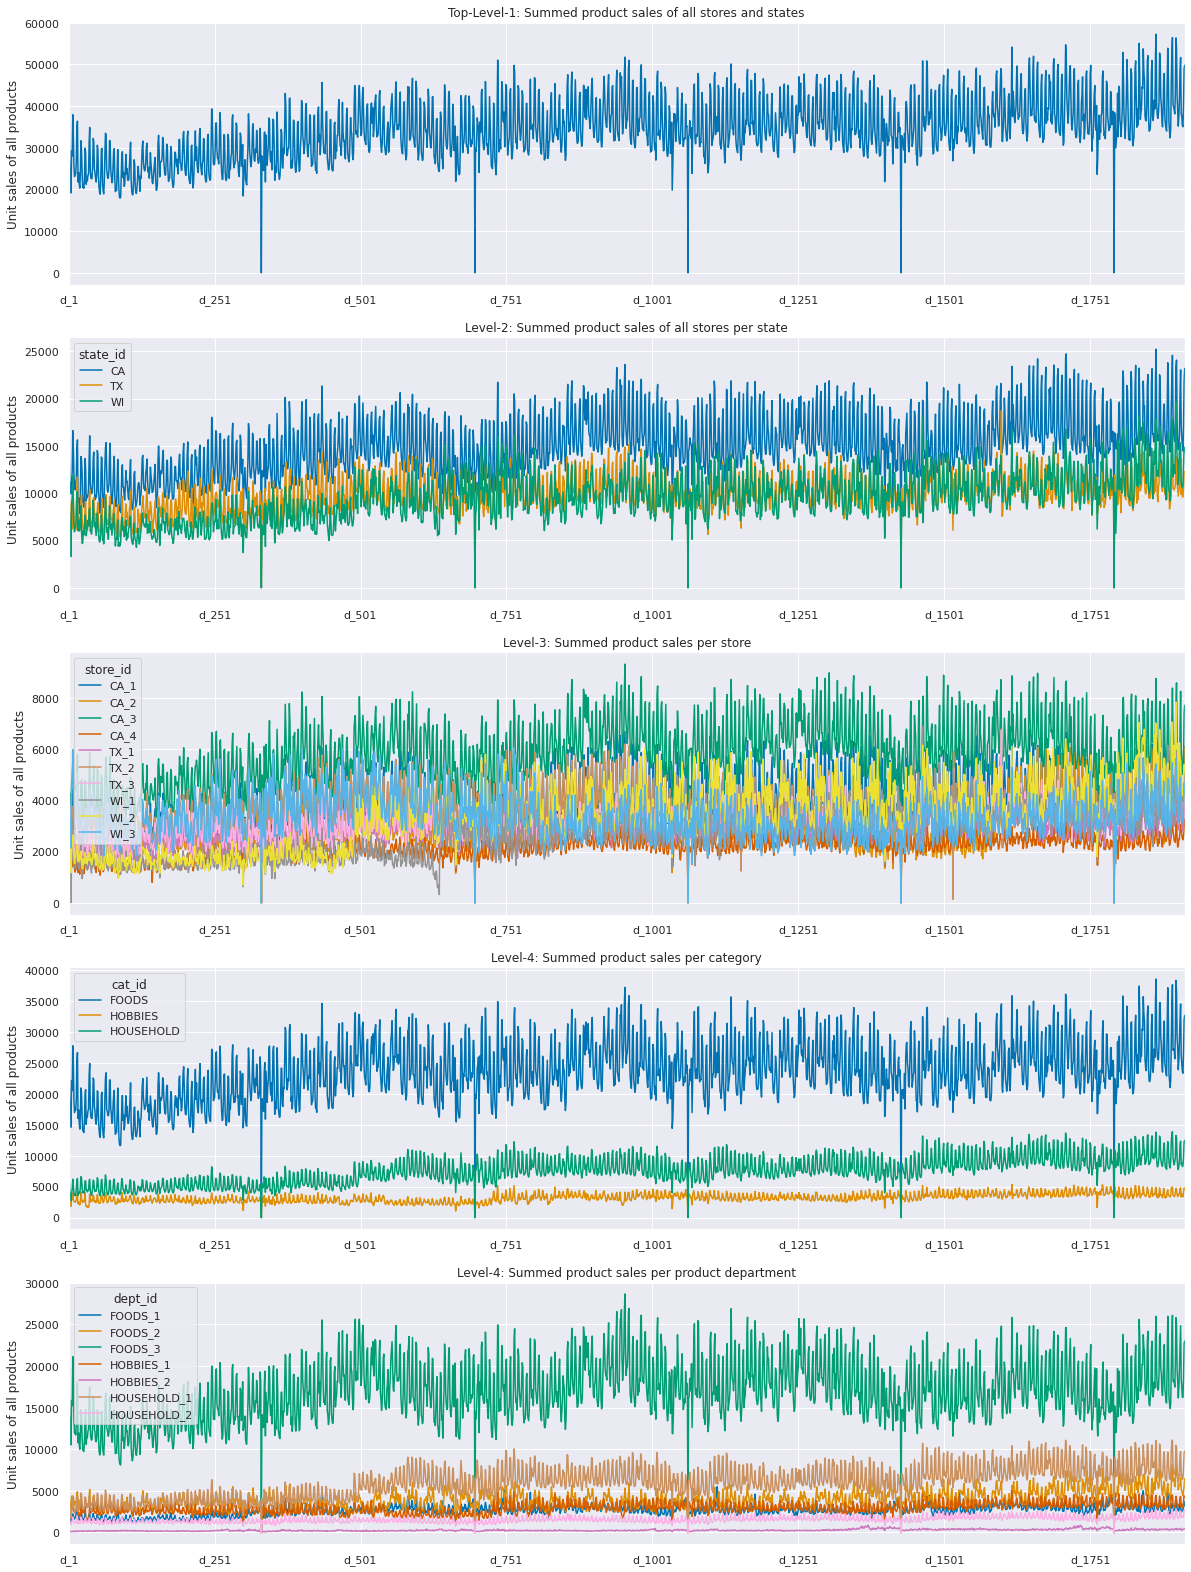

In [8]:
sns.set_palette("colorblind")

fig, ax = plt.subplots(5,1,figsize=(20,28))
train[series_cols].sum().plot(ax=ax[0])
ax[0].set_title("Top-Level-1: Summed product sales of all stores and states")
ax[0].set_ylabel("Unit sales of all products");
train.groupby("state_id")[series_cols].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Level-2: Summed product sales of all stores per state");
ax[1].set_ylabel("Unit sales of all products");
train.groupby("store_id")[series_cols].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Level-3: Summed product sales per store")
ax[2].set_ylabel("Unit sales of all products");
train.groupby("cat_id")[series_cols].sum().transpose().plot(ax=ax[3])
ax[3].set_title("Level-4: Summed product sales per category")
ax[3].set_ylabel("Unit sales of all products");
train.groupby("dept_id")[series_cols].sum().transpose().plot(ax=ax[4])
ax[4].set_title("Level-4: Summed product sales per product department")
ax[4].set_ylabel("Unit sales of all products");

### Insights

* It has become much clearer how these levels are aggregated by performing groupby- and summing up the sales.
* We can already observe nice periodic patterns. 

## How can we generate forecasts for grouped timeseries? <a class="anchor" id="forecasts_ts"></a>

* Our training data consists of 30490 timeseries. They belong to the bottom-level 12: Unit sales of product x, aggregated for each store.
* A simple method to generate forecasts for all levels is to focus only on the bottom level. All of its predictions are then summed up to create the forecasts of all levels up to the top. This is called the bottom-up approach. 
* As you can see [here](https://otexts.com/fpp2/bottom-up.html), there are many more approaches one could use, for example top-down or middle-out. 

# The submission format <a class="anchor" id="submission"></a>

## Intro <a class="anchor" id="intro"></a>

* We have 28 F-columns as we are predicting daily sales for the next 28 days. 
* We are asked to make uncertainty estimates for these days.

In [9]:
submission = pd.read_csv("/kaggle/input/m5-forecasting-uncertainty/sample_submission.csv")
submission.head(10)

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  ...  F19  \
0  Total_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
1     CA_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
2     TX_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
3     WI_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
4   CA_1_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
5   CA_2_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
6   CA_3_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
7   CA_4_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
8   TX_1_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   
9   TX_2_X_0.005_validation   0   0   0   0   0   0   0   0   0  ...    0   

   F20  F21  F22  F23  F24  F25  F26  F27  F28  
0    0    0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0    0    0  
4    0    0    0    0    0    0    0    0    0  
5    0    0    0    0    0    0    0    0    0  
6    0    0    0    0    0    0    0    0    0  
7    0    0    0    0    0    0    0    0    0  
8    0    0    0    0    0    0    0    0    0  
9    0    0    0    0    0    0    0    0    0  

[10 rows x 29 columns]

In [10]:
submission.shape

(771120, 29)

* In the first submission row we are asked to make precitions for the top level 1 (unit sales of all products, aggregated for all stores/states)
* The next 3 rows represent level 2.
* Followed by level 3. 
* This may goes on and on until the bottom level 12 is reached? Probably not as there seem to be only 3 combinations of ids.
* Some rows contain aggregations at different levels. An X indicates the absence of an second aggregration level.
* The prediction interval can be validation (related to the public leaderboard) or evaluation (related to the private leaderboard).

## Prediction intervals and quartiles <a class="anchor" id="PIs"></a>

Reading in the competition guideline, we can find that we are asked to make predictions for the median and four prediction intervals (PI): 50%, 67%, 95% and 99%. They belong to the following quartiles:

* 99% PI - $u_{1} = 0.005$ and $u_{9} = 0.995$
* 95% PI - $u_{2} = 0.025$ and $u_{8} = 0.975$
* 67% PI - $u_{3} = 0.165$ and $u_{7} = 0.835$
* 50% PI - $u_{4} = 0.25$ and $u_{6} = 0.75$
* median - $u_{5} = 0.5$

## Aggregation levels <a class="anchor" id="sub_aggregation_levels"></a>

In [11]:
np.random.choice(submission.id.values, replace=False, size=15)

array(['TX_FOODS_1_187_0.165_validation',
       'CA_HOBBIES_1_262_0.835_validation',
       'FOODS_3_360_CA_3_0.250_evaluation',
       'TX_HOBBIES_1_051_0.005_evaluation',
       'FOODS_3_051_CA_4_0.835_validation',
       'WI_HOUSEHOLD_2_468_0.025_validation',
       'WI_HOUSEHOLD_1_266_0.250_evaluation',
       'HOUSEHOLD_1_043_TX_3_0.250_evaluation',
       'HOUSEHOLD_1_440_TX_3_0.500_validation',
       'FOODS_2_365_TX_1_0.165_validation',
       'HOUSEHOLD_1_330_TX_2_0.835_evaluation',
       'FOODS_1_141_WI_1_0.975_validation',
       'FOODS_3_498_WI_3_0.975_evaluation',
       'FOODS_2_224_TX_3_0.835_validation',
       'HOUSEHOLD_2_135_TX_1_0.500_evaluation'], dtype=object)

Browsing through the submission ids, we can see that we are given values of $u_{i}$ and information about the aggregation type like:

* the state id
* the department id
* the item id
* the store id

It's a bit confusing that missing states are not represented by X. This makes splitting the id for EDA a bit more complicated. :-( Furthermore there is no clear separator. The $ \_ $ sign is also present in the department id. **It seems that one asked aggregation always consists of 3 ids. In cases of counts smaller than 3, we can observe X as placeholder.**  

## Submission EDA <a class="anchor" id="submission_eda"></a> 

In [12]:
def find_quartil(l):
    
    if "0.005" in l:
        return 0.005
    elif "0.025" in l:
        return 0.025
    elif "0.165" in l:
        return 0.165
    elif "0.25" in l:
        return 0.25
    elif "0.5" in l:
        return 0.5
    elif "0.75" in l:
        return 0.75
    elif "0.835" in l:
        return 0.835
    elif "0.975" in l:
        return 0.975
    elif "0.995" in l:
        return 0.995
    else:
        return 0
    
def find_state(l):
    if "CA" in l:
        return "CA"
    elif "TX" in l:
        return "TX"
    elif "WI" in l:
        return "WI"
    else:
        return "Unknown"
    
def find_category(l):
    if "FOODS" in l:
        return "foods"
    elif "HOBBIES" in l:
        return "hobbies"
    elif "HOUSEHOLD" in l:
        return "household"
    else:
        return "Unknown"

In [13]:
submission_eda = pd.DataFrame(submission.id, columns=["id"])
submission_eda.loc[:, "lb_type"] = np.where(submission.id.str.contains("validation"), "validation", "evaluation")
submission_eda.loc[:, "u"] = submission.id.apply(lambda l: find_quartil(l))
submission_eda.loc[:, "state"] = submission.id.apply(lambda l: find_state(l))
submission_eda.loc[:, "category"] = submission.id.apply(lambda l: find_category(l))

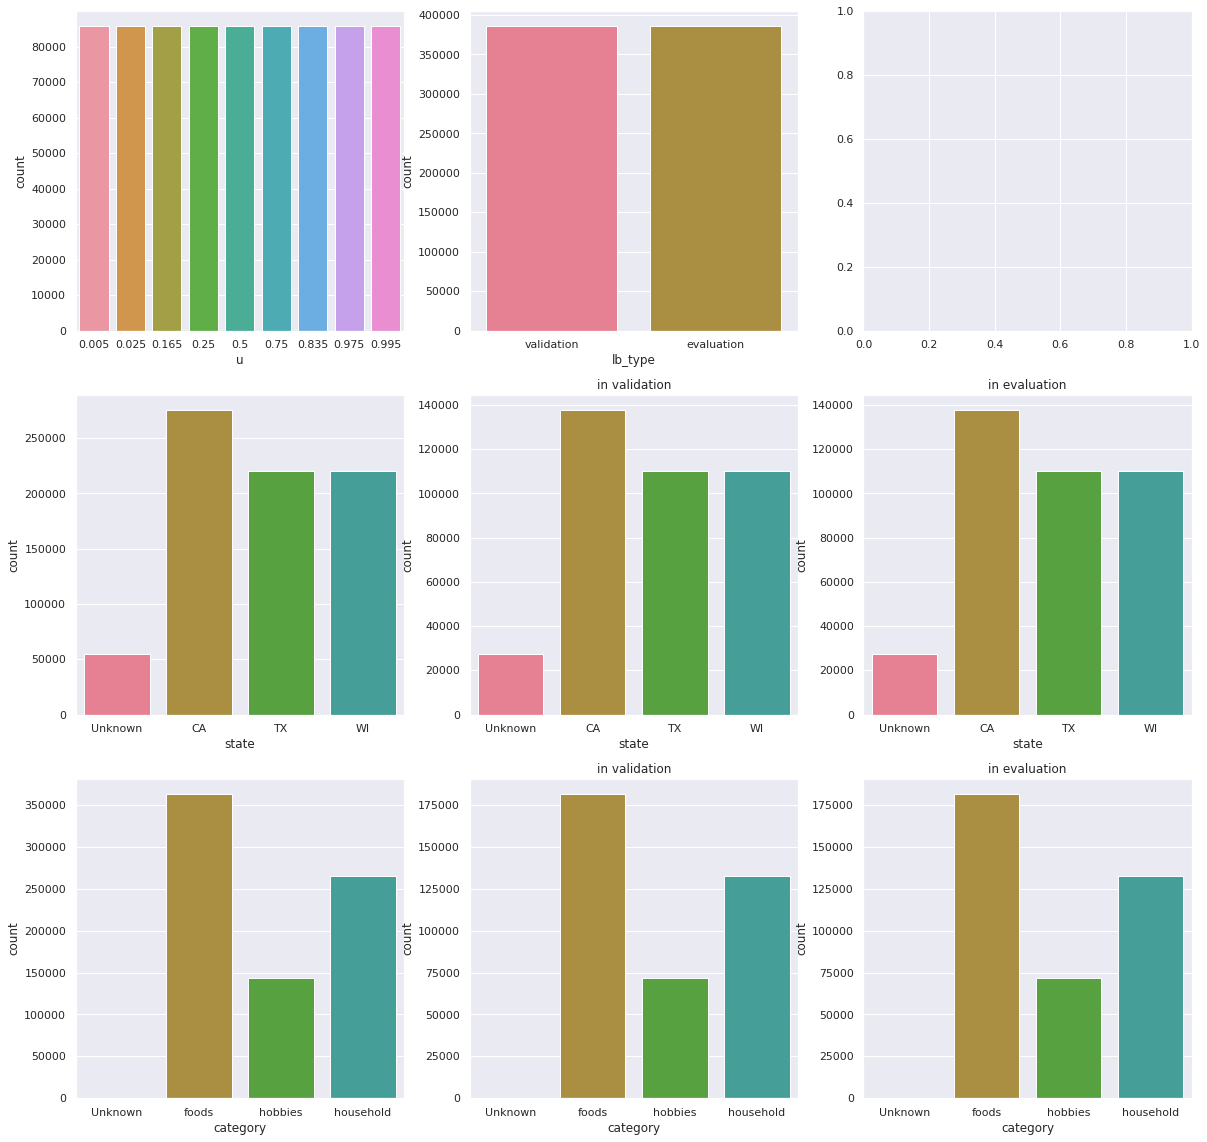

In [14]:
sns.set_palette("husl")

fig, ax = plt.subplots(3,3,figsize=(20,20))
sns.countplot(submission_eda.u, ax=ax[0,0]);
sns.countplot(submission_eda.lb_type, ax=ax[0,1]);
sns.countplot(submission_eda.state, ax=ax[1,0]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="validation"].state, ax=ax[1,1]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="evaluation"].state, ax=ax[1,2]);
sns.countplot(submission_eda.category, ax=ax[2,0]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="validation"].category, ax=ax[2,1]);
sns.countplot(submission_eda.loc[submission_eda.lb_type=="evaluation"].category, ax=ax[2,2]);
for n in range(1,3):
    ax[n,2].set_title("in evaluation")
    ax[n,1].set_title("in validation")

### Insights

* Each quartile u has exactily $2*42840 = 85680$ requests. The total number of all 12 level timeseries is 42840.
* We have the same number of validation and evaluation requests and this explains the factor 2.
* It seems that really all 12 aggregation levels are represented in the submission id. This is not clear yet and can be shown with further EDA (work in progress).

# The Weighted Scaled Pinball loss <a class="anchor" id="loss"></a>

## The formula <a class="anchor" id="formula"></a>

For each time series and for each quantile the **Scaled Pinball loss** can be computed by:

$$ SPL(u) = \frac{1}{h} \cdot \frac{1}{\frac{1}{n-1} \cdot \sum_{t=2}^{n} |Y_{t} - Y_{t-1}|} \cdot \sum_{t=n+1}^{n+h}
\begin{cases} 
    (Y_{t} - Q_{t}(u))\cdot u & \text{if } Y_{t} \geq Q_{t}(u) \\
    (Q_{t}(u) - Y_{t})\cdot (1-u)       & \text{if } Y_{t} < Q_{t}(u)
\end{cases} $$

whereas:

* $Y_{t}$ is the actual true future value of the time series at point $t$
* $u$ is the considered quantile
* $Q_{t}$ is the generated forecast for quantile $u$
* $h$ is the forecasting horizon (28 days)
* $n$ is the length of the training sample (number of historical observations)

After computing this loss for all 42840 time series and for all requested quantiles, the **Weighted Scaled Pinball** loss is computed as follows:

$$ WSPL = \sum_{i=1}^{42840} \cdot w_{i} \cdot \frac{1}{9} \sum_{j=1}^{9}SPL(u_{j})$$

In the M5 competiton we have 12 aggregation levels and as all hierarchical levels are equally weighted the weights should be $w_{i}=\frac{1}{12}$. The total number of time series is higher than what is given in train as all levels up to the top aggregation are included.



## Playing with the loss implementation <a class="anchor" id="loss_implementation"></a>

Let's pick a single timeseries to get started with the loss and its implementation. As I just like to get started it's a bit quick and dirty and surely not the best way to write it down. ;-) 


In [15]:
def spl_denominator(train_series):
    N = len(train_series)
    sumup = 0
    for n in range(1, N):
        sumup += np.abs(train_series[n]-train_series[n-1])
    return sumup/(N-1)

In [16]:
def spl_numerator(dev_series, Q, u):
    sumup = 0
    for m in range(len(dev_series)):
        if Q[m] <= dev_series[m]:
            sumup += (dev_series[m] - Q[m])*u
        else:
            sumup += (Q[m] - dev_series[m])*(1-u)
    return sumup

In [17]:
def spl(train_series, dev_series, Q, u):
    h = len(dev_series)
    spl_denomina = spl_denominator(train_series)
    spl_numera = spl_numerator(dev_series, Q, u)
    
    return spl_numera/(h*spl_denomina)

# The Naive method <a class="anchor" id="naive"></a>

To really compute the loss for our example we need to make quantile forecasts $Q_{t}(u)$ for a given quantile $u$. So far we haven't setup a model, but we can start easily using the naive method described in the competition guideline:

$Y_{n+i} = Y_{n}$

for $i=1,2,...h$.

It's used for predicting series of the lowest level of the hierarchy. You can see that this approach just assumes the last known daily sale value for all requested predictions of the series. 


## Prediction intervals for the Naive method <a class="anchor" id="prediction_intervals_naive"></a>


### Assuming normally distributed forcasting errors

But how can we compute prediction intervals for this method? If we always assume the last known value for the next points of the time period with horizont h, there would be no distribution per time point that could tell us something about uncertainty. I really start to like [Forecasting - Principles and Practice](https://otexts.com/fpp2/). Take a look at the chapter ["Prediction intervals"](https://otexts.com/fpp2/prediction-intervals.html#prediction-intervals). Here we can read that one way to go is to assume normally distributed forcasting errors:

$$\epsilon(y) \sim N(\sigma_{h})$$

whereas $\sigma_{h}$ stands for the estimated standard deviation of future time step h. A prediction interval is then computed as a multiple of this standard deviation:

$$y_{lower, h} = y - c \cdot \sigma_{h}$$

$$y_{upper, h} = y + c \cdot \sigma_{h}$$

The factor $c$ is called **multiplier** and often such values are used for the requested prediction intervals:

* c = 2.58 for 99% PI
* c = 1.96 for 95% PI
* c ~ 0.95 for 67% PI
* c = 0.67 for 50% PI

If you like to read more about prediction intervals, I found this [Wikipedia article](https://en.wikipedia.org/wiki/Prediction_interval) useful as well.

### Prediction intervals for multi-step time horizonts

In our case we are asked to compute uncertainty estimates for a time period of 28 days. It's intuitive that our predictions become more uncertain the greater the time step $h$ of our time horizont. Therefore we can assume that $\sigma_{h}$ increases with h. 


In contrast to one-step predictions we can't just use the standard deviation $\sigma$ of residuals $\epsilon_{t} = y_{true, t} - y_{fitted, t}$ of all time points $t$ between our observations and fitted values of the training data. Instead we could use some common benchmark methods:

* **Mean forcasts: $\sigma_{h} = \sigma \cdot \sqrt{1 + \frac{1}{T}}$ **
* **Naive forcasts:** $\sigma_{h} = \sigma \cdot \sqrt{h}$
* **Seasonal naive forcasts:** $\sigma_{h} = \sigma \cdot \sqrt{k+1}$ with k as the integer part of $\frac{(h-1)}{m}$ and $m$ as the seasonal period
* **Drift forcasts:** $\sigma_{h} = \sigma \cdot \sqrt{h \cdot \left(\frac{1+h}{T}\right) }$

In these cases $T$ stands for the total time span in the training data and $h$ for our prediction time horizont (in our case 28 days). All methods assume that we have given uncorrelated residuals. Consequently we need to perform a residual analysis to check if this is true! :-) 


But before doing so, we need to compute an example of the Naive method! 

## Computing the loss for one timeseries of level 12 <a class="anchor" id="loss_example"></a>

In [18]:
idx = 1000

In [19]:
train[level_cols].iloc[idx]

id          HOUSEHOLD_1_445_CA_1_validation
item_id                     HOUSEHOLD_1_445
dept_id                         HOUSEHOLD_1
cat_id                            HOUSEHOLD
store_id                               CA_1
state_id                                 CA
Name: 1000, dtype: object

Ok, we can see that this series represents all daily sales of item 445 in the CA_1 store. This item is part of the household_1 department and is also present as a row in the other shops:

In [20]:
train.loc[train.item_id=="HOUSEHOLD_1_445"].store_id.unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

Let's take a look at the daily sales of this series:

In [21]:
plt.figure(figsize=(20,5))
plt.plot(train[series_cols].iloc[idx].values, 'o')
plt.title("Item 445 daily sales in shop CA_1");
plt.xlabel("observed days")
plt.ylabel("Unit sales");

Now, we need to split our single row data into a training and validation (dev) part. I decided to use the same period of time (28 days) for validation:

In [22]:
timeseries = train[series_cols].iloc[idx].values
h = 28

train_timeseries = timeseries[0:len(timeseries)-h]
dev_timeseries = timeseries[(len(timeseries)-h)::]

print(len(train_timeseries), len(dev_timeseries))

1885 28


Then we choose the last known value of the train timeseries as predictions for all asked 28 time points: 

In [23]:
naive_val = train_timeseries[-1]
naive_Q = np.ones(dev_timeseries.shape) * naive_val
naive_Q

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In this case all predictions are zero. Let's compute the loss for the median:

In [24]:
spl(train_timeseries, dev_timeseries, naive_Q, 0.5)

0.8187879588064431

## Residual analysis 

Ok, let's start with the computation of residuals for our example time series. As we assumed that the last known value is valid for all future values, I would choose this one also as fitted value for all training data points in the past:

In [25]:
naive_val

0

In [26]:
residuals = train_timeseries - naive_val

In [27]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(residuals, ax=ax[0], kde=False)
ax[0].set_xlabel("residuals")
ax[0].set_ylabel("frequency");
ax[0].set_title("Distribution of residuals");

In [28]:
np.mean(residuals)

2.3745358090185675

### Insights

* As the last known value was 0 and this value is also the only possible minimum value, we do not observe a normal distribution of residuals!
* Furthermore the mean of our residuals is not zero. In this case they are called biased and it's also an indicator that our model does not suite well.
* I have decided to compute this example for the bottom level 12. In contrast to top-level time series the corresponding series do not show nice and clear periodic patterns that would likely yield more normally distributed residuals. 
* Consequently we may conclude that some methods and models could be better suited for top or low-level series in the hierarchy but not for both. This is something to keep in mind.

### Computing prediction intervals

Now we need to choose a benchmark to compute how the predictions become more unsecure when time moves on. As I'm on the "naive" way, I like to use $\sigma_{h} = \sigma \cdot \sqrt{h}$. Let's do it for this single time series example:

In [29]:
std_dev = np.std(residuals)
std_h = np.ones(dev_timeseries.shape)

for h in range(1, 29):
    std_h[h-1] = std_dev * np.sqrt(h)

In [30]:
std_h

array([ 2.09300689,  2.95995873,  3.62519427,  4.18601378,  4.68010568,
        5.1267989 ,  5.53757572,  5.91991746,  6.27902067,  6.61866893,
        6.94171853,  7.25038854,  7.54644366,  7.83131468,  8.10618082,
        8.37202755,  8.62968848,  8.87987618,  9.12320551,  9.36021136,
        9.5913625 ,  9.81707249, 10.03770841, 10.25359781, 10.46503444,
       10.67228297, 10.87558281, 11.07515144])

Ok, the rest now is simple. We have seen that we can compute PIs using our multipliers:

$$y_{lower, h} = y - c \cdot \sigma_{h}$$

$$y_{upper, h} = y + c \cdot \sigma_{h}$$

* c = 2.58 for 99% PI
* c = 1.96 for 95% PI
* c ~ 0.95 for 67% PI
* c = 0.67 for 50% PI

I will only use one as an example: c=2.58 for 99% PI:

In [31]:
y_lower = np.ones(len(std_h))
y_upper = np.ones(len(std_h))
for h in range(len(std_h)):
    low_val = naive_Q[h] - 2.58 * std_h[h]
    if low_val < 0:
        y_lower[h] = 0
    else:
        y_lower[h] = low_val
    y_upper[h] = naive_Q[h] + 2.58 * std_h[h]

In [32]:
plt.figure(figsize=(20,5))
plt.plot(y_lower, c="r", label="0.005 boundary")
plt.plot(y_upper, c="g", label="0.995 boundary")
plt.plot(naive_Q, 'o', c="b", label="predicted value")
plt.title("Computing 99% PI for one timeseries of level 12");
plt.xlabel("time horizont h=28 days")
plt.ylabel("Unit sales");
plt.legend();

# Facebook's Prophet <a class="anchor" id="prophet"></a>


## Model description

[Prophet](https://facebook.github.io/prophet/) is a decomposable time series model with 3 main model components and one error term:

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$$

* trend g(t) - non-periodic changes of the value
* seasonality s(t) - periodic changes (e.g. weekly and yearly) 
* holidays h(t) - effect of holidays (e.g. irregular patterns over one or more days)
* $\epsilon_{t}$ - error term that describes any idiosyncratic changes (assumed to be normally distributed)


## Uncertainty estimates

By default it returns uncertainty intervals of the predicted value $y_{hat}$ consisting of three different sources:
* uncertainty in the trend,
* uncertainty in the seasonality estimates,
* additional observation noise

To compute the uncertainty in the trend it is assumed that the average frequency and magnitude of trend changes will be the same in the future as observed in the history. This trend changes are projected forward into the future and by computing their distribution uncertainty intervals are obtained. **By default Prophet only returns uncertainty in the trend and observation noise!**

## Example - Total unit sales prediction

Let's sum up all unit sales given in our training data to obtain the top level time series of total unit sales of all stores and states:

In [33]:
timeseries = train[series_cols].sum().values
len(timeseries)

1913

As we are asked to predict a time window of 28 days, the easiest way to go now is to use the last 28 days for validation: 

In [34]:
train_timeseries = timeseries[0:-28]
eval_timeseries = timeseries[-28::]
print(len(train_timeseries), len(eval_timeseries))
days = np.arange(1, len(series_cols)+1)

1885 28


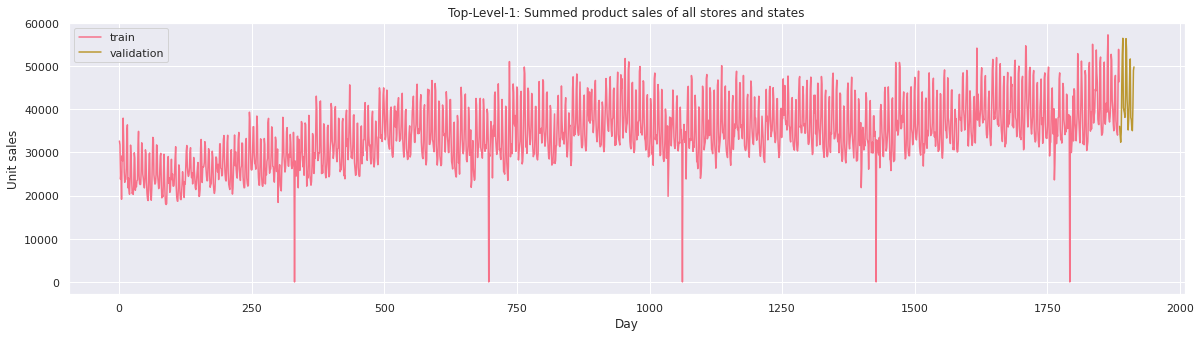

In [35]:
plt.figure(figsize=(20,5))
plt.plot(days[0:-28], train_timeseries, label="train")
plt.plot(days[-28::], eval_timeseries, label="validation")
plt.title("Top-Level-1: Summed product sales of all stores and states");
plt.legend()
plt.xlabel("Day")
plt.ylabel("Unit sales");

As far as I currently know Prophet likes to have the dates that we can find in our calendar dataframe:

In [36]:
dates = calendar.iloc[0:len(timeseries)].date.values
df = pd.DataFrame(dates, columns=["ds"])
df.loc[:, "y"] = timeseries
df.head()

ds      y
0  2011-01-29  32631
1  2011-01-30  31749
2  2011-01-31  23783
3  2011-02-01  25412
4  2011-02-02  19146

In [37]:
train_df = df.iloc[0:-28]
train_df.shape

(1885, 2)

In [38]:
eval_df = df.iloc[-28::]
eval_df.shape

(28, 2)

In [39]:
uncertainty_interval_width = 0.25

In [40]:
m = Prophet(interval_width=uncertainty_interval_width)
m.fit(train_df)
future = m.make_future_dataframe(periods=28)
forecast = m.predict(future)
forecast.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2011-01-29  23523.964684  29213.618451  31624.693770  23523.964684   
1 2011-01-30  23537.560789  29182.421010  31349.802522  23537.560789   
2 2011-01-31  23551.156893  20767.515052  23031.736209  23551.156893   
3 2011-02-01  23564.752998  18774.460000  20820.207159  23564.752998   
4 2011-02-02  23578.349102  18427.498965  20661.767395  23578.349102   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  23523.964684     6955.980646           6955.980646           6955.980646   
1  23537.560789     6591.871032           6591.871032           6591.871032   
2  23551.156893    -1497.238600          -1497.238600          -1497.238600   
3  23564.752998    -3909.698304          -3909.698304          -3909.698304   
4  23578.349102    -4157.959802          -4157.959802          -4157.959802   

        weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
0  7191.739496   7191.739496   7191.739496 -235.758850   -235.758850   
1  6738.973883   6738.973883   6738.973883 -147.102851   -147.102851   
2 -1441.086641  -1441.086641  -1441.086641  -56.151959    -56.151959   
3 -3946.718498  -3946.718498  -3946.718498   37.020194     37.020194   
4 -4290.146729  -4290.146729  -4290.146729  132.186927    132.186927   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0   -235.758850                   0.0                         0.0   
1   -147.102851                   0.0                         0.0   
2    -56.151959                   0.0                         0.0   
3     37.020194                   0.0                         0.0   
4    132.186927                   0.0                         0.0   

   multiplicative_terms_upper          yhat  
0                         0.0  30479.945330  
1                         0.0  30129.431820  
2                         0.0  22053.918293  
3                         0.0  19655.054694  
4                         0.0  19420.389300

In [41]:
col_int = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
forecast[col_int].head()

ds          yhat    yhat_lower    yhat_upper
0 2011-01-29  30479.945330  29213.618451  31624.693770
1 2011-01-30  30129.431820  29182.421010  31349.802522
2 2011-01-31  22053.918293  20767.515052  23031.736209
3 2011-02-01  19655.054694  18774.460000  20820.207159
4 2011-02-02  19420.389300  18427.498965  20661.767395

In [42]:
plt.plot(forecast.iloc[-28::].yhat.values, 'o', label="predicted yhat")
plt.plot(eval_df.y.values, 'o-', label="target")
plt.legend();

In [43]:
fig = plot_plotly(m, forecast)  
py.iplot(fig)

## Submission for validation

Remember that we are asked to predict the following intervals PI:

* 99% PI - $u_{1} = 0.005$ and $u_{9} = 0.995$
* 95% PI - $u_{2} = 0.025$ and $u_{8} = 0.975$
* 67% PI - $u_{3} = 0.165$ and $u_{7} = 0.835$
* 50% PI - $u_{4} = 0.25$ and $u_{6} = 0.75$
* median - $u_{5} = 0.5$

Now let's fit the whole training data and predict for the validation timeperiod of the submission file. We have to set the interval in advance and personally it feels a bit overcomplicated to do so for each requested interval. But as I still need to understand Prophet in its details I'm going the following way:  

In [44]:
uncertainty_interval_width = 0.25

In [45]:
f_cols = [col for col in submission.columns if "F" in col]

In [46]:
submission_val = submission[submission.id.str.contains("validation")].copy()

In [47]:
def plugin_total_predictions():
    
    for uncertainty_interval_width in [0.005, 0.025, 0.165, 0.25]:
        upper = 1-uncertainty_interval_width
        lower = uncertainty_interval_width
    
        m = Prophet(interval_width=uncertainty_interval_width)
        m.fit(df)
        future = m.make_future_dataframe(periods=28)
        forecast = m.predict(future)
    
        submission_val.loc[
            (submission_val.id.str.contains("Total")) & (submission_val.id.str.contains(str(lower))),f_cols
        ] = np.round(forecast.yhat_lower.values[-28::])
    
        submission_val.loc[
            (submission_val.id.str.contains("Total")) & (submission_val.id.str.contains(str(upper))),f_cols
        ] = np.round(forecast.yhat_upper.values[-28::])
    
    submission_val.loc[
        (submission_val.id.str.contains("Total")) & (submission_val.id.str.contains(str(0.5))),f_cols
    ] = forecast.yhat.values[-28::]
    
    return submission_val

In [48]:
submission_val = plugin_total_predictions()
submission_val.loc[submission_val.id.str.contains("Total")]

id            F1            F2            F3  \
0       Total_X_0.005_validation  39476.206385  36941.672204  36534.831365   
42840   Total_X_0.025_validation  39476.206385  36941.672204  36534.831365   
85680   Total_X_0.165_validation  38837.000000  36348.000000  35822.000000   
128520  Total_X_0.250_validation  38242.000000  36024.000000  35423.000000   
171360  Total_X_0.500_validation  39476.206385  36941.672204  36534.831365   
214200  Total_X_0.750_validation  40536.000000  38146.000000  37563.000000   
257040  Total_X_0.835_validation  40244.000000  37672.000000  37191.000000   
299880  Total_X_0.975_validation  39572.000000  36970.000000  36471.000000   
342720  Total_X_0.995_validation  39458.000000  37296.000000  36713.000000   

                  F4           F5            F6            F7            F8  \
0       36683.992166  40661.35736  47981.580512  47525.242916  39235.189447   
42840   36683.992166  40661.35736  47981.580512  47525.242916  39235.189447   
85680   36302.000000  39742.00000  47273.000000  46890.000000  38236.000000   
128520  35457.000000  39423.00000  46726.000000  46545.000000  38207.000000   
171360  36683.992166  40661.35736  47981.580512  47525.242916  39235.189447   
214200  37619.000000  41627.00000  48931.000000  48674.000000  40478.000000   
257040  37580.000000  41253.00000  48779.000000  48271.000000  39752.000000   
299880  36876.000000  40679.00000  48246.000000  47643.000000  39137.000000   
342720  36639.000000  40514.00000  48203.000000  47492.000000  39211.000000   

                  F9  ...           F19          F20           F21  \
0       36716.196952  ...  40509.007418  47891.11493  47502.673617   
42840   36716.196952  ...  40509.007418  47891.11493  47502.673617   
85680   35987.000000  ...  39654.000000  47120.00000  46774.000000   
128520  35780.000000  ...  39346.000000  46650.00000  46434.000000   
171360  36716.196952  ...  40509.007418  47891.11493  47502.673617   
214200  37857.000000  ...  41589.000000  48777.00000  48527.000000   
257040  37590.000000  ...  41282.000000  48524.00000  48010.000000   
299880  36892.000000  ...  40626.000000  47861.00000  47508.000000   
342720  36684.000000  ...  40441.000000  48039.00000  47716.000000   

                F22           F23           F24           F25           F26  \
0       39286.81185  36848.424776  36544.545564  36803.560757  40897.595085   
42840   39286.81185  36848.424776  36544.545564  36803.560757  40897.595085   
85680   38836.00000  36152.000000  35987.000000  36090.000000  40149.000000   
128520  38263.00000  35761.000000  35343.000000  36007.000000  39867.000000   
171360  39286.81185  36848.424776  36544.545564  36803.560757  40897.595085   
214200  40282.00000  37892.000000  37452.000000  37950.000000  41993.000000   
257040  40100.00000  37724.000000  37395.000000  37513.000000  41455.000000   
299880  39314.00000  36962.000000  36599.000000  36898.000000  41028.000000   
342720  39461.00000  36818.000000  36535.000000  37027.000000  41026.000000   

                F27          F28  
0       48341.04577  48014.04299  
42840   48341.04577  48014.04299  
85680   47726.00000  47476.00000  
128520  47038.00000  46879.00000  
171360  48341.04577  48014.04299  
214200  49232.00000  49186.00000  
257040  49112.00000  48911.00000  
299880  48716.00000  48341.00000  
342720  48453.00000  47993.00000  

[9 rows x 29 columns]

I'm not sure if this whole stuff makes sense. Personally I feel a strong need for Bayesian ML oand [credible intervals](https://en.wikipedia.org/wiki/Credible_interval). What I miss most is a much more detailed mathematical description of Prophet in the documentation. Only using the model without a deeper understanding of what is going on feels very sloppy and dangerous. :-(

# LSTM and bootstrapped residuals <a class="anchor" id="lstm_bootstrapped_res"></a>

## Basic idea <a class="anchor" id="basic_idea"></a>

* Here we are using the Frequentist perspective of probability:
    * The model parameters $w$ are assumed to be fixed and we estimate it using our estimator. 
    * The estimation depends on the dataset D we observe and consequently we can obtain error bars for our estimated parameters $w_{est}$ by considering multiple datasets.
    * One way to do this is by creating new datasets, for example with bootstrapping.
* We are creating new datasets by using bootstrapped residuals:
    * We only assume uncorrelated residuals that need not be normally distributed.

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Setting up LSTM <a class="anchor" id="lstm_setup"></a>

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [51]:
class MyLSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, batch_size, num_layers=1, output_dim=1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size=self.input_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=self.num_layers,
                            dropout = 0.25)
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        
    def init_hidden(self):
        self.h_zero = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device)
        self.c_zero = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device)
    
    def forward(self, x):
        lstm_output, (h_n, c_n) = self.lstm(x.view(len(x), self.batch_size, -1),
                                           (self.h_zero, self.c_zero))
        last_time_step = lstm_output.view(self.batch_size, len(x), self.hidden_dim)[-1]
        pred = self.linear(last_time_step)
        return pred
    

def train_model(model, data_dict, lr=1e-4, num_epochs=500):
    
    loss_fun = torch.nn.MSELoss(reduction="mean")
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = np.zeros(num_epochs)
    phases = ["train", "eval"]
    losses_dict = {"train": [], "eval": []}
    predictions_dict = {"train": [], "eval": [] }
    
    for n in range(num_epochs):
        
        for phase in phases:
            
            x = data_dict[phase]["input"].to(device, dtype=torch.float)
            y = data_dict[phase]["target"].to(device, dtype=torch.float)
            
            if phase == "train":
                model.train()
            else:
                model.eval()
        
            optimiser.zero_grad()
            
            model.init_hidden()
            y_pred = model(x)
            
            if n == (num_epochs-1):
                predictions_dict[phase] = y_pred.float().cpu().detach().numpy()
            
            loss = loss_fun(y_pred.float(), y)
            losses_dict[phase].append(loss.item())
            
            if n % 50 == 0:
                print("{} loss: {}".format(phase, loss.item()))
            
            if phase == 'train':
                loss.backward()
                optimiser.step()
        
    return losses_dict, predictions_dict

def create_sequences(timeseries, seq_len):
    inputs = []
    targets = []
    
    max_steps = len(timeseries) - (seq_len+1)
    
    for t in range(max_steps):
        x = timeseries[t:(t+seq_len)]
        y = timeseries[t+seq_len]
        inputs.append(x)
        targets.append(y)
    
    return np.array(inputs), np.array(targets)

## The top timeseries - preprocessing <a class="anchor" id="preprocessing"></a>

Let's use the timeseries of total unit sales as an example again. For preprocessing we should remove the trend and scale the values.

In [52]:
diff_series = np.diff(timeseries)
train_size = np.int(0.7 * len(diff_series))
train_diff_series = diff_series[0:train_size]
eval_diff_series = diff_series[train_size::]
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_train = scaler.fit_transform(train_diff_series.reshape(-1, 1))
scaled_eval = scaler.transform(eval_diff_series.reshape(-1,1))

In [53]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(scaled_train, '-o', c="b")
ax[1].plot(scaled_eval, '-o', c="g")
ax[0].set_title("Single preprocessed top timeseries in train")
ax[1].set_title("Single preprocessed top timeseries in eval");
ax[0].set_xlabel("Days in dataset")
ax[1].set_xlabel("Days in dataset")
ax[0].set_ylabel("$\Delta y$ scaled")
ax[1].set_ylabel("$\Delta y$ scaled");

## Fitting the model to the top-level series <a class="anchor" id="fitting_lstm"></a>

In [54]:
seq_len = 400
input_dim = 1
hidden_dim = 128
num_epochs = 600
lr=0.0005


x_train, y_train = create_sequences(scaled_train, seq_len)
x_eval, y_eval = create_sequences(scaled_eval, seq_len)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_eval = torch.from_numpy(x_eval).float()
y_eval = torch.from_numpy(y_eval).float()

data_dict = {"train": {"input": x_train, "target": y_train},
             "eval": {"input": x_eval, "target": y_eval}}

In [55]:
model = MyLSTM(input_dim=input_dim,
               hidden_dim=hidden_dim,
               batch_size=seq_len)
model = model.to(device)

In [56]:
run_training = True
if run_training:
    losses_dict, predictions_dict = train_model(model, data_dict, num_epochs=num_epochs, lr=lr)

train loss: 0.03215865418314934
eval loss: 0.05486249551177025
train loss: 0.025395847856998444
eval loss: 0.04536266624927521
train loss: 0.017710372805595398
eval loss: 0.03874075040221214
train loss: 0.017076322808861732
eval loss: 0.03733029216527939
train loss: 0.016008879989385605
eval loss: 0.03474303334951401
train loss: 0.012479265220463276
eval loss: 0.026960983872413635
train loss: 0.01128946989774704
eval loss: 0.024573516100645065
train loss: 0.011240986175835133
eval loss: 0.024303585290908813
train loss: 0.011195646598935127
eval loss: 0.024037476629018784
train loss: 0.011153318919241428
eval loss: 0.023782942444086075
train loss: 0.011113647371530533
eval loss: 0.023539504036307335
train loss: 0.011075932532548904
eval loss: 0.023308593779802322


In [57]:
if run_training:
    
    fig, ax = plt.subplots(3,1,figsize=(20,20))
    ax[0].plot(losses_dict["train"], '.-', label="train", c="red")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("MSE")
    ax[0].plot(losses_dict["eval"], '.-', label="eval", c="blue");
    ax[0].legend();

    ax[1].plot(predictions_dict["train"], '-o', c="red")
    ax[1].plot(y_train, '-o', c="green")
    ax[1].set_title("Fitted and true values of y in train");
    ax[1].set_ylabel("Unit sales y");
    ax[1].set_xlabel("Number of days in train");

    ax[2].plot(predictions_dict["eval"], '-o', c="red")
    ax[2].plot(y_eval, '-o', c="green")
    ax[2].set_title("Predicted and true values of y in eval");
    ax[2].set_xlabel("Number of days in eval");
    ax[2].set_ylabel("Unit sales y");

## Check residuals for autocorrelation <a class="anchor" id="residuals_checkup"></a>

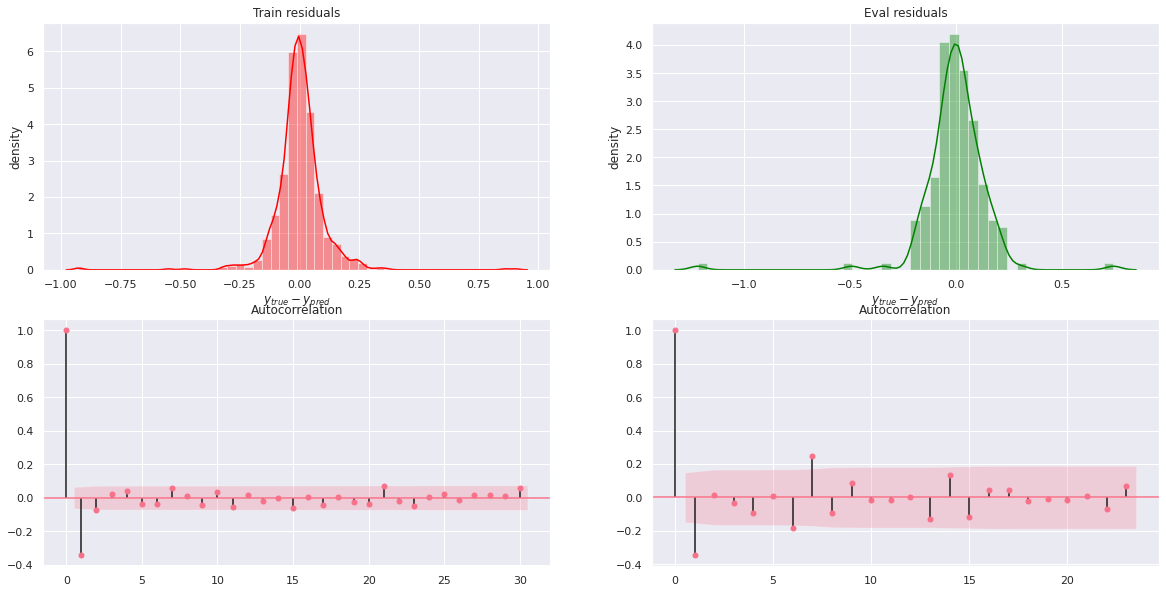

In [58]:
from statsmodels.graphics.tsaplots import plot_acf

if run_training:
    
    train_residuals = y_train-predictions_dict["train"]
    eval_residuals = y_eval-predictions_dict["eval"]
    
    fig, ax = plt.subplots(2,2,figsize=(20,10))
    sns.distplot(train_residuals, ax=ax[0,0], color="red")
    sns.distplot(eval_residuals, ax=ax[0,1], color="green")
    ax[0,0].set_title("Train residuals")
    ax[0,1].set_title("Eval residuals")
    ax[0,0].set_xlabel("$y_{true} - y_{pred}$")
    ax[0,1].set_xlabel("$y_{true} - y_{pred}$")
    ax[0,0].set_ylabel("density")
    ax[0,1].set_ylabel("density")
    
    plot_acf(train_residuals, ax=ax[1,0])
    plot_acf(eval_residuals, ax=ax[1,1])

### Insights

* The residuals in train only show a significant autocorrelation with their previous, 1-lag timepoint. 
* That's great as we are close to uncorrelated residuals that were assumed when using bootstrapped residuals.

## Computing PIs using bootstrapped residuals <a class="anchor" id="bootstrapped_PIs"></a>

The idea of computing PIs using bootstrapped residuals is as follows:

1. Fit the model to your data to obtain the fitted values $\hat{y}_{i}$ and the forcasting errors $\epsilon_{i} = y_{true, i} - \hat{y}_{i}$.
2. Randomly sample a residual $\epsilon_{i}$ of the distribution of all $\epsilon_{j}$ to generate a new response variable $y^{*}$ using the fitted value: $y^{*} = \hat{y}_{i} + \epsilon_{i}$. 
3. Doing this repeatively we obtain many different, synthetic values for future predictions that we can use to compute prediction intervals.

Let's take a look at a single example first:

In [59]:
sampled_residuals = np.random.choice(train_residuals[:, 0], size=len(y_train), replace=True)
sampled_residuals = sampled_residuals.reshape(-1,1)
new_response = predictions_dict["train"] + sampled_residuals

In [60]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
ax[0,0].plot(predictions_dict["train"][0:200], 'o-', color="purple")
ax[0,0].set_title("Original fitted values $y_{pred}$ in ")
ax[0,0].set_xlabel("200 example days")
ax[0,0].set_ylim(-0.4, 0.4)
ax[0,0].set_ylabel("$y_{fitted}$")

ax[0,1].plot(new_response[0:200,0], 'o-', color="orange")
ax[0,1].set_title("Response values $y^{*}$ using sampled residuals");
ax[0,1].set_xlabel("200 example days")
ax[0,1].set_ylabel("$y^{*}$");
ax[0,1].set_ylim(-0.4, 0.4)

ax[1,0].plot(sampled_residuals[0:200], 'o-', color="cornflowerblue")
ax[1,0].set_title("Sampled residuals")
ax[1,0].set_xlabel("200 example days")
ax[1,0].set_ylabel("$\epsilon$")

ax[1,1].plot(y_train[0:200], 'o-', color="firebrick")
ax[1,1].set_title("True values $y_{train}$")
ax[1,1].set_xlabel("200 example days")
ax[1,1].set_ylabel("$y_{train}$");


We need to compute PIs for evaluation and validation data. In my case, I have splitted the original training timeseries into my own eval and train part. Consequently instead of computing response series for the training data, we need to do this for the evaluation data. While doing so we also need to reverse the preprocessing:

In [61]:
responses = []
for n in range(100):
    # sample residuals using the historical residuals found in train
    sampled_residuals = np.random.choice(train_residuals[:, 0], size=len(y_eval), replace=True)
    sampled_residuals = sampled_residuals.reshape(-1,1)
    # create a synthetic future timeseries of eval by adding sampled residuals
    new_response = predictions_dict["eval"] + sampled_residuals
    # reverse the scaling
    new_response = scaler.inverse_transform(new_response)
    # concat the first value of the evaluation series and the response series
    new_response = np.hstack((timeseries[train_size], new_response[:,0]))
    # reverse the differnciation (trend removal) using cumsum
    new_response = np.cumsum(new_response)
    # save the future timeseries
    responses.append(new_response)
    
responses = np.array(responses)
responses.shape

(100, 174)

In [62]:
y_eval.shape

torch.Size([173, 1])

In [63]:
median_series = np.median(responses, axis=0)
eval_series = scaler.inverse_transform(y_eval)
eval_series = np.cumsum(np.hstack((timeseries[train_size-1], eval_series[:,0])))
low_q = 0.25
up_q = 0.75

In [64]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(0, len(median_series)), median_series, 'o-', label="median predicted series")
plt.plot(eval_series, '.-', color="cornflowerblue", label="true eval series")
lower = np.quantile(responses, low_q, axis=0)
upper = np.quantile(responses, up_q, axis=0)
plt.fill_between(np.arange(0, len(median_series)), lower, upper, alpha=0.5)
plt.title("Prediction interval {}% of eval timeseries".format((up_q-low_q)*100));
plt.xlabel("Days in eval")
plt.ylabel("Unit sales");
plt.legend();

### Insights

* We can see that our median series is often close to the true eval timeseries.
* But the predictions become more uncertain with increasing time horizont.
* We were not able to cover heavy, periodic outliers so far. 
* Nonetheless I'm still impressed that the bootstrapped residuals seem to work not so bad as I expected it. :-)

# Where to go next? <a class="anchor" id="next"></a>

I'm going to continue with the following topics:

* More about Prophet and personal adjustments - computing PIs
* Conclusion of what I have learnt by writing this kernel